Carga de librerías

In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from yaml import safe_load
from scipy.special import logit, expit
from sklearn.linear_model import LogisticRegression

Definición de rutas relativas del archivo

In [2]:
ROOT = os.path.dirname(os.getcwd())
DATA = os.path.join(ROOT, 'data')

Carga de archivo de configuración

In [3]:
with open(file=os.path.join(ROOT, 'config.yml'), mode='r') as file:
    CONFIG = safe_load(file)
file.close()

# Regresión Logística

La regresión logística es la manera estándar de modelar variables respuesta binarias.

## Predictores únicos

Para ilustar el funcionamiento básico de una regresión logística, se empieza partiendo de una regresión con un único predictor de un problema de preferencias políticas electorales en las elecciones de 1992 de USA, ignorando aquellos votos que se abstuvieron o que votaron por representantes distintos a los partidos Republicano y Demócrata

In [4]:
# Carga de datos completos
datos = pd.read_csv(
    os.path.join(DATA, 'ideo.csv'))

# Filtrar datos para regresión pred. único
datos_predictor_unico = (
    datos
    .query(expr="year == 1992")
    .query(expr="presvote < 3")
    .filter(items=['income', 'presvote'])
    .assign(vote = lambda _df: _df.presvote - 1)
    .reset_index(drop=True))

Se hace una inspección visual rápida de los datos

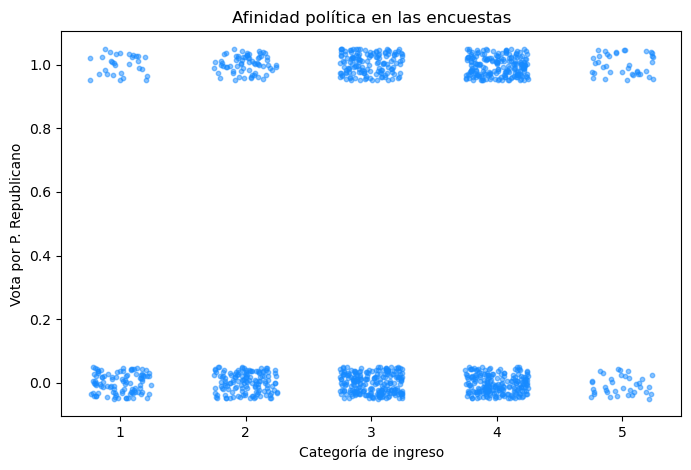

In [5]:
# Especificaciones de figura
fig, ax = plt.subplots(figsize = (8,5))

# Elementos de visualización
x_jitter = np.random.uniform(low=-0.25, high=0.25, size=datos_predictor_unico.shape[0])
y_jitter = np.random.uniform(low=-0.05, high=0.05, size=datos_predictor_unico.shape[0])

ax.scatter(
    x=datos_predictor_unico.income + x_jitter
    ,y=datos_predictor_unico.vote + y_jitter
    ,s=10
    ,color=CONFIG['graficas']['colors']['azul']
    ,alpha=0.5)

# Anotaciones y estilo
ax.set(
    title='Afinidad política en las encuestas'
    ,xlabel='Categoría de ingreso'
    ,ylabel='Vota por P. Republicano')

plt.show()

Al obsevar los datos, en realidad se puede ver que no hace ningún sentido modelar una regresión lineal ya que esto excedería el dominio de la variable predictora. En cambio, se puede modelar la probabilidad de que $y=1$ con la expresión:

$$P(y=1)=logit^{-1}(X_i\beta)$$

Bajo el supuesto de que las respuestas $y_i$ son independientes dada la distribución de probabilidad. El término $X_i\beta$ representa los predictores lineales, y la función $logit^{-1}$ se encarga de transformar valores continuos al rango $(0, 1)$, lo cual es necesario dado que se están modelando probabilidades, y está dado por la expresión:

$$logit^{-1}(x)=\frac{e^x}{1+e^x}$$

Para entenderlo mejor, otra forma de ver el modelo es la siguiente. Se sabe que la probabilidad $P(y_i=1)\in(0,1)$, por lo que si se iguala a un valor $p_i$ entonces $p_i\in(0,1)$, es decir:

$$P(y_i=1)=p_i$$

Esta probabilidad proviene de las variables explicativas $X_i\beta\in\mathbb{R}$, y sabiendo que la función $logit(x): x\in(0,1)\rightarrow x\in\mathbb{R}$, entonces se puede justificar la igualdad:

$$logit(p_i)=X_i\beta$$

Que al aplicar la función $logit^{-1}$ en ambos lados de la igualdad, recurpera la expresión original.

### Modelo con `sklearn`

In [6]:
# Datos de modelado
x_train = datos_predictor_unico.income.to_numpy().reshape((-1,1))
y_train = datos_predictor_unico.vote.to_numpy()

# Iniciar instancia de modelo
log_reg = LogisticRegression()

# Entrenamiento y resumen
results = log_reg.fit(x_train, y_train)
results.intercept_, results.coef_

(array([-1.39881016]), array([[0.32494336]]))

### Modelo con `statsmodels`

In [7]:
# Datos de modelado
x_train = datos_predictor_unico.income
y_train = datos_predictor_unico.vote

# Agregar intercepto
x_train = sm.add_constant(data=x_train)

# Iniciar instancia de modelo
log_reg = sm.Logit(endog=y_train, exog=x_train)

# Entrenamiento y resumen
results = log_reg.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.660270
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   vote   No. Observations:                 1179
Model:                          Logit   Df Residuals:                     1177
Method:                           MLE   Df Model:                            1
Date:                Wed, 23 Aug 2023   Pseudo R-squ.:                 0.02157
Time:                        17:22:31   Log-Likelihood:                -778.46
converged:                       True   LL-Null:                       -795.62
Covariance Type:            nonrobust   LLR p-value:                 4.672e-09
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4021      0.189     -7.401      0.000      -1.773      -1.031
income         0.3260      0.057      5.731      0.000       0.215       0.437
==============================================================================
"""

Los resultados del modelo anterior pueden visualizarse si se resuelve el modelo para un rango dado

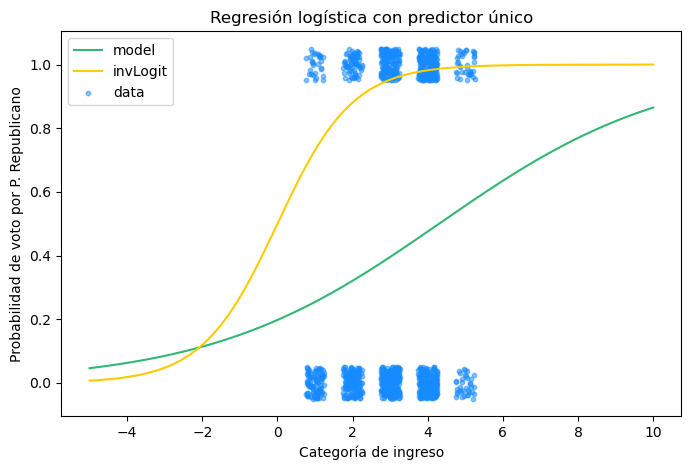

In [8]:
# Malla para mapear el modelo
x_vis = np.linspace(start=-5, stop=10, num=datos_predictor_unico.shape[0])

# Predicciones del modelo
y_vis = np.array([
    expit(results.params['const'] + results.params['income'] * x_vis)
    ,log_reg.cdf(X=x_vis)
])

# Especificaciones de figura
fig, ax = plt.subplots(figsize = (8,5))

# Elementos de visualización
ax.plot(
    x_vis, y_vis[0]
    ,color=CONFIG['graficas']['colors']['verde']
    ,label='model')
ax.plot(
    x_vis, y_vis[1]
    ,color=CONFIG['graficas']['colors']['amarillo']
    ,label='invLogit')
ax.scatter(
    x=datos_predictor_unico.income + x_jitter
    ,y=datos_predictor_unico.vote + y_jitter
    ,s=10
    ,label='data'
    ,color=CONFIG['graficas']['colors']['azul']
    ,alpha=0.5)

# Anotaciones y estilo
ax.set(
    title='Regresión logística con predictor único'
    ,xlabel='Categoría de ingreso'
    ,ylabel='Probabilidad de voto por P. Republicano')
ax.legend()

plt.show()

Para interpretar estos resultados es necesario evaluar el cambio en la probabilidad $P(y_i=1)$ cuando $x$ toma algún valor, por ejemplo la media $\bar{x}$

In [9]:
# Promeido de categoría de ingreso
x_mean = datos_predictor_unico.income.mean()

print(f"P(y=1) en x=media: {expit(results.params['const'] + results.params['income'] * x_mean) * 100:.2f} %")

P(y=1) en x=media: 40.14 %


En el valor promedio de la categoría de ingreso, la $P(y=1)=40\%$.

Otra forma de interpretar los coeficientes es evaluando el cambio en la probabilidad cuando $x$ cambia en una unidad, por ejemplo, de una categoría de ingreso $2\rightarrow 3$

In [10]:
# Probabilidades que se van a comparar
p_2 = expit(results.params['const'] + results.params['income'] * 2)
p_3 = expit(results.params['const'] + results.params['income'] * 3)

print(f"Cambio en P(y=1) cuando X: (2 -> 3): {(p_3 - p_2) * 100:.2f} %")

Cambio en P(y=1) cuando X: (2 -> 3): 7.47 %


Pasar de un nivel de ingreso de $2\rightarrow 3$ incrementa la probabilidad $P(y=1)$ en $7.5\%$